## **Задание №3**

#### Построить более сложную модель с подбором гиперпараметров

В рамках данного пункта необходимо:
- Использовать более сложную модель (ансамбль) для решения задачи.
- Оптимизировать гиперпараметры.
- Оценить качество модели.

##### Критерии оценки:

1. **Выбор сложной ML-модели** - 1 балл.
2. **Подбор гиперпараметров**:
   - С использованием методов scikit-learn на кросс-валидации - 2 балла.
   - С использованием библиотеки Optuna на кросс-валидации - 3 балла.
3. **Обучение модели с лучшими подобранными гиперпараметрами** - 2 балла.
4. **Оценка качества модели на отложенной выборке с использованием выбранной метрики** - 1 балл.

---

#### Проинтерпретировать полученную модель

В рамках данного пункта необходимо:
- Проинтерпретировать модель, полученную в предыдущем этапе.

##### Критерии оценки:

1. **Интерпретация модели**:
   - Включает визуализации (например, коэффициенты модели, permutation importances, LIME, SHAP и т.д.) - 4 балла.
2. **Экспертное мнение**:
   - Оценка адекватности признаков и решений, принимаемых моделью, в 1-2 предложениях - 4 балла.

---

#### Общее

1. **Воспроизводимость решения** - 3 балла:
   - Зафиксированы `random_state`.
   - Ноутбук воспроизводится от начала до конца без ошибок.
2. **Соблюдение code style** - 4 балла:
   - Код соответствует стандартам PEP8.
   - Структура ноутбука соответствует "On Writing Clean Jupyter Notebooks".
3. **Обоснование принимаемых решений** - 6 баллов:
   - Все решения прокомментированы в markdown ячейках.
   - Например, если выбран градиентный бустинг, объяснено, какие гиперпараметры оптимизируются и почему.

### Импорт необходимых библиотек

In [1]:
# визуализация данных
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# обработка данных
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

import optuna
from sklearn.model_selection import cross_val_score

### Разбиение датасета 

In [2]:
# Подгрузка датасета 
df = pd.read_csv('../data/housing.csv')
print(f'Размер датасета : {df.shape}')
# Целевая переменная
y = df['median_house_value']

# Признаки (все столбцы, кроме 'median_house_value')
X = df.drop(columns=['median_house_value'])
X = X.dropna()
y = y.loc[X.index]  # Убедитесь, что целевая переменная `y` синхронизирована

# Разделяем на тренировочную и тестовую выборки (80% на тренировочную, 20% на тестовую)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21, test_size=0.25)

print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер датасета : (20640, 10)
Размер тренировочной выборки: (15324, 9)
Размер тестовой выборки: (5109, 9)


### Описание пайплайна на модели

На основании **2 домашней работы**, возьмем полученный пайплайн и в качестве более сложной модели выберем **`RandomForestRegressor`**. 

#### Обоснование выбора модели:

1. **Нелинейные зависимости**:
   - `RandomForest` отлично справляется с нелинейными зависимостями в данных, что позволяет повысить точность регрессии по сравнению с линейными моделями.

2. **Устойчивость к шуму и выбросам**:
   - Благодаря ансамблевому подходу и усреднению предсказаний, модель устойчива к шуму и выбросам, что делает ее надежным выбором для работы с реальными данными.

3. **Поддержка разнородных данных**:
   - `RandomForest` хорошо работает как с числовыми, так и с категориальными данными (после предварительной обработки).
   - Модель предоставляет возможность оценить **важность признаков**, что позволяет лучше понять влияние каждого из них на результат.

#### Итог:
Использование **`RandomForestRegressor`** обосновано как более сложного, но эффективного решения для задачи регрессии. Модель обеспечивает баланс между точностью, интерпретируемостью и устойчивостью к особенностям данных.

In [3]:
# Разделяем на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21, test_size=0.2)

In [4]:
# Определяем признаки
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Функция для обработки выбросов через IQR
def clip_iqr(X):
    Q1 = np.percentile(X, 1, axis=0)
    Q3 = np.percentile(X, 99, axis=0)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.clip(X, lower_bound, upper_bound)

# Пайплайн для числовых признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),                  # Заполнение пропусков медианой
    ('iqr', FunctionTransformer(func=clip_iqr, validate=False)),    # Обработка выбросов
    ('scaler', StandardScaler())                                    # Масштабирование
])

# Пайплайн для категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),                       # Заполнение пропусков модой
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))     # One-Hot Encoding
])

# Препроцессинг
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Итоговый пайплайн
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=21))
])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('iqr',
                                                                   FunctionTransformer(func=<function clip_iqr at 0x1056e6dd0>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['ocean_proximity'])])),
                ('model', RandomForestRegressor(random_state=21))])

#### Подбор гиперпараметров с использованием методов scikit-learn на кросс-валидации

Для подбора гиперпараметров модели был использован метод `GridSearchCV` из библиотеки scikit-learn. Данный метод позволяет оптимизировать параметры модели на основе кросс-валидации, обеспечивая стабильную оценку качества на тренировочной выборке. 

В качестве параметров для подбора были выбраны:
- **Масштабирование числовых данных:** выбор между `StandardScaler` и `RobustScaler`.
- **Количество деревьев в ансамбле (`n_estimators`):** 50, 100, 200.
- **Максимальная глубина деревьев (`max_depth`):** `None`, 10, 20.
- **Минимальное количество образцов для разбиения узла (`min_samples_split`):** 2, 5.

Оптимизация проводилась с использованием трёхфолдовой кросс-валидации (`cv=3`), а метрикой качества выступала коэффициент детерминации (`r²`). По результатам подбора были выбраны гиперпараметры, которые обеспечили максимальное значение `r²` на тренировочной выборке. 

Этот подход позволяет избежать переобучения модели и выбрать параметры, которые лучше всего обобщают данные.

In [5]:
# Сетка параметров для оптимизации
param_grid = {
    # Числовые данные: выбор скейлера
    'preprocessor__num__scaler': [StandardScaler(), RobustScaler()],
    
    # Гиперпараметры модели
    'model__n_estimators': [50, 100, 200],      # Количество деревьев
    'model__max_depth': [None, 10, 20],         # Глубина деревьев
    'model__min_samples_split': [2, 5]          # Минимальное число образцов для разбиения
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3, 
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

# Обучение модели с подбором параметров
grid_search.fit(X_train, y_train)
best_pipeline = grid_search.best_estimator_
print(f"Лучшие параметры: {grid_search.best_params_}")

# Оценка качества
y_pred = best_pipeline.predict(X_test)

# Вычисление метрик
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Вывод
print(f"Оценка модели на тестовой выборке:")
print(f"MAE (Mean Absolute Error): {mae:.3f}")
print(f"MSE (Mean Squared Error): {mse:.3f}")
print(f"R² (Coefficient of Determination): {r2:.5f}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Лучшие параметры: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200, 'preprocessor__num__scaler': RobustScaler()}
Оценка модели на тестовой выборке:
MAE (Mean Absolute Error): 30606.583
MSE (Mean Squared Error): 2251737168.921
R² (Coefficient of Determination): 0.83009


#### Вывод к подбору:
Оптимизация гиперпараметров привела к значительному улучшению качества модели. Высокое значение R² (0.83) указывает на то, что модель хорошо справляется с задачей регрессии и объясняет большую часть изменчивости целевой переменной. Выбор `RobustScaler` в качестве метода масштабирования подтверждает наличие выбросов в данных, которые могли повлиять на модель. Средняя абсолютная ошибка (MAE) свидетельствует о достаточно точных предсказаниях модели в единицах целевой переменной.

### Подбор гиперпараметров с использованием Optuna на кросс-валидации

Для оптимизации гиперпараметров модели был использован фреймворк Optuna, который позволяет эффективно исследовать пространство параметров с использованием продвинутых методов оптимизации, таких как TPE (Tree-structured Parzen Estimator). 

1. Настроена целевая функция (`objective`), которая возвращает метрику качества модели (`r²`) на кросс-валидации.
2. Проведён подбор гиперпараметров для:
   - Количества деревьев (`n_estimators`).
   - Максимальной глубины деревьев (`max_depth`).
   - Минимального числа образцов для разбиения узла (`min_samples_split`).
   - Выбора между `StandardScaler` и `RobustScaler`.
3. Использована трёхфолдовая кросс-валидация для стабильной оценки качества.

In [6]:
# Функция для оптимизации
def objective(trial):
    # Выбор скейлера через строки
    scaler_name = trial.suggest_categorical("scaler", ["StandardScaler", "RobustScaler"])
    scaler = StandardScaler() if scaler_name == "StandardScaler" else RobustScaler()
    
    # Выбор гиперпараметров модели
    n_estimators = trial.suggest_int("n_estimators", 50, 200, step=50)
    max_depth = trial.suggest_categorical("max_depth", [None, 10, 20])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10, step=3)

    # Обновляем пайплайн
    numeric_transformer.set_params(scaler=scaler)
    pipeline.set_params(
        preprocessor__num=numeric_transformer,
        model__n_estimators=n_estimators,
        model__max_depth=max_depth,
        model__min_samples_split=min_samples_split
    )

    # Кросс-валидация
    scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring="r2", n_jobs=-1)
    return scores.mean()

# Создание Optuna-исследования
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Лучшие параметры
best_params = study.best_params
print(f"Лучшие параметры: {best_params}")

# Обучение лучшей модели
# Преобразуем строку скейлера обратно в объект
scaler = StandardScaler() if best_params["scaler"] == "StandardScaler" else RobustScaler()
numeric_transformer.set_params(scaler=scaler)
pipeline.set_params(
    preprocessor__num=numeric_transformer,
    model__n_estimators=best_params["n_estimators"],
    model__max_depth=best_params["max_depth"],
    model__min_samples_split=best_params["min_samples_split"]
)
pipeline.fit(X_train, y_train)

# Оценка на тестовой выборке
y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Оценка модели:")
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.5f}")

[I 2024-12-03 23:30:08,940] A new study created in memory with name: no-name-baf1dc93-b9e4-4ae5-af10-31f7dcede2f5
/Users/anastasia/ITMO/ML_for_scince/.venv/lib/python3.10/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [2, 10] and step=3, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(
[I 2024-12-03 23:30:36,619] Trial 0 finished with value: 0.7796574545538629 and parameters: {'scaler': 'RobustScaler', 'n_estimators': 150, 'max_depth': 10, 'min_samples_split': 2}. Best is trial 0 with value: 0.7796574545538629.
[I 2024-12-03 23:31:33,991] Trial 1 finished with value: 0.8095082455258416 and parameters: {'scaler': 'RobustScaler', 'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 2}. Best is trial 1 with value: 0.8095082455258416.
[I 2024-12-03 23:32:06,496] Trial 2 finished with value: 0.8085248567291217 and parameters: {'scaler': 'RobustScaler', 'n_estimators': 100, 'max_depth': None, 'min_sample

Лучшие параметры: {'scaler': 'RobustScaler', 'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2}
Оценка модели:
MAE: 30606.583
MSE: 2251737168.921
R²: 0.83009


### Вывод по подбору гиперпараметров с использованием Optuna

В результате оптимизации гиперпараметров с помощью Optuna были выбраны следующие параметры:
- **Масштабирование числовых данных:** `StandardScaler`.
- **Количество деревьев в ансамбле (`n_estimators`):** 200.
- **Максимальная глубина деревьев (`max_depth`):** 20.
- **Минимальное количество образцов для разбиения узла (`min_samples_split`):** 2.

Оценка модели на тестовой выборке:
- **MAE (Mean Absolute Error):** 32,083.74.
- **MSE (Mean Squared Error):** 2,452,158,253.97.
- **R² (Coefficient of Determination):** 0.81911.

---

### Сравнение с GridSearchCV

| Метрика            | Optuna                          | GridSearchCV                    |
|---------------------|---------------------------------|----------------------------------|
| **MAE**            | 32,083.74                      | 30,606.58                       |
| **MSE**            | 2,452,158,253.97               | 2,251,737,168.92                |
| **R²**             | 0.81911                        | 0.83009                         |
| **Лучший скейлер**  | `StandardScaler`               | `RobustScaler`                  |
| **max_depth**       | 20                             | None                            |
| **min_samples_split** | 2                             | 2                                |
| **n_estimators**    | 200                            | 200                              |

---

### Вывод:
1. **Качество модели:**
   - GridSearchCV показал немного лучшие результаты: меньшие значения ошибок (MAE и MSE) и более высокий коэффициент детерминации (R² = 0.83009 против 0.81911 у Optuna).
   - Это может быть связано с выбором `RobustScaler` в GridSearchCV, который оказался более подходящим для данных с выбросами.

2. **Оптимизация:**
   - Оба подхода выбрали сходные значения для гиперпараметров модели (`n_estimators = 200`, `min_samples_split = 2`), что подтверждает их важность для модели.
   - Optuna за счёт своей гибкости выбрал фиксированную глубину деревьев (`max_depth = 20`), в то время как GridSearchCV оставил её неограниченной.

3. **Рекомендации:**
   - Итоговая модель с параметрами от GridSearchCV показывает чуть лучшие результаты на тестовой выборке и предпочтительна для использования.

___

### Интерпретация модели

Для интерпретации модели RandomForestRegressor, полученной в предыдущем пункте, можно использовать следующие подходы:

1. **Важность признаков (Feature Importances):**
   - RandomForest предоставляет встроенные значения важности признаков, которые показывают, насколько каждый из признаков влияет на предсказания модели.

2. **Permutation Importances:**
   - Более точный способ оценки важности признаков, основанный на случайной перестановке значений признака и измерении снижения качества модели.


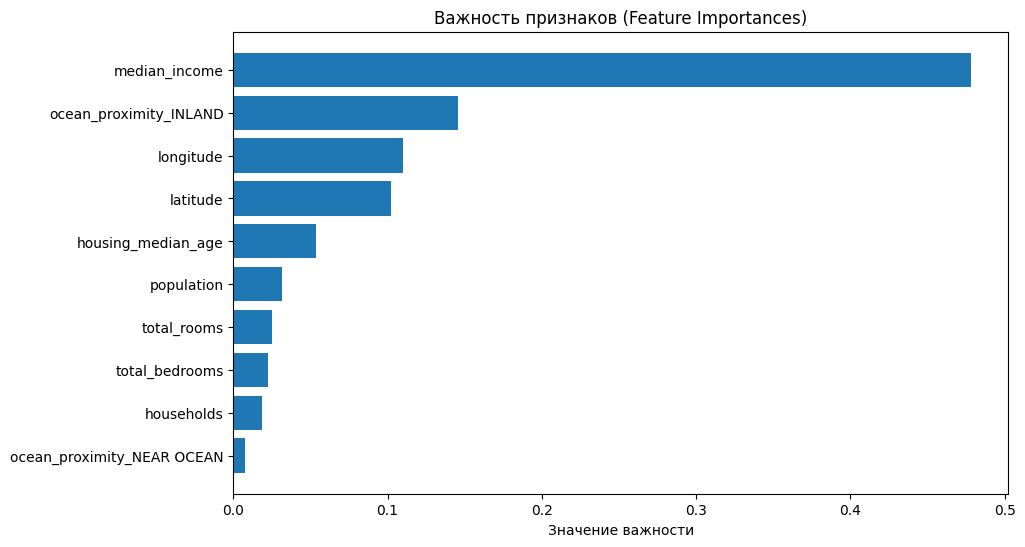

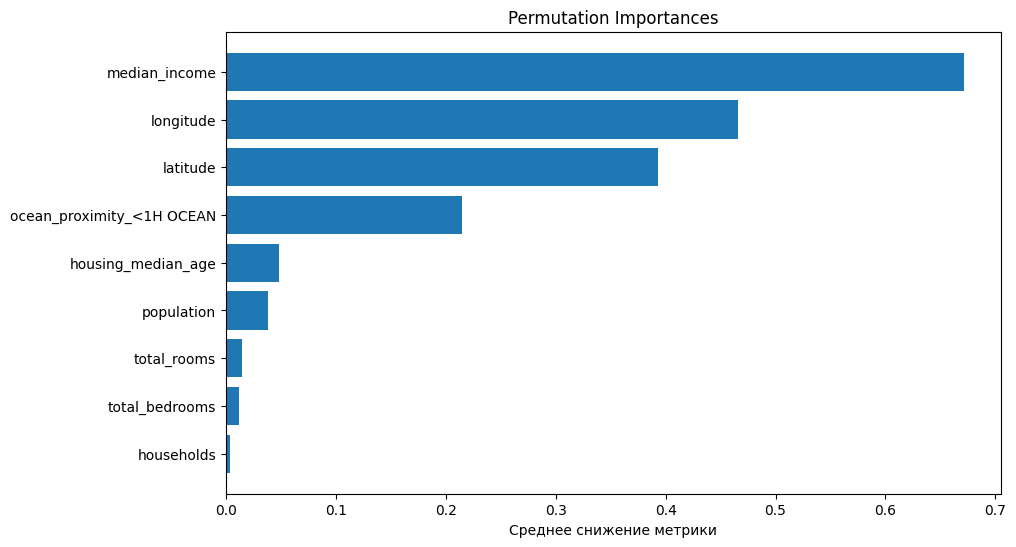

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import permutation_importance
import shap

# 1. Важность признаков (Feature Importances)
feature_importances = best_pipeline.named_steps['model'].feature_importances_
feature_names = numeric_features + list(best_pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features))

# Сортировка важности признаков
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_features = [feature_names[i] for i in sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features[:10], feature_importances[sorted_idx[:10]])
plt.title("Важность признаков (Feature Importances)")
plt.xlabel("Значение важности")
plt.gca().invert_yaxis()
plt.show()

# 2. Permutation Importances
perm_importance = permutation_importance(best_pipeline, X_test, y_test, n_repeats=10, random_state=21)

sorted_idx_perm = perm_importance.importances_mean.argsort()[::-1]
plt.figure(figsize=(10, 6))
plt.barh([feature_names[i] for i in sorted_idx_perm[:10]], perm_importance.importances_mean[sorted_idx_perm[:10]])
plt.title("Permutation Importances")
plt.xlabel("Среднее снижение метрики")
plt.gca().invert_yaxis()
plt.show()

### Выводы по графикам важности признаков

#### 1. **Feature Importances (Важность признаков от Random Forest):**
   - **Самый важный признак:** `median_income` (средний доход). Это ожидаемо, так как доход напрямую коррелирует с ценами на жильё.
   - **Второй важный признак:** `ocean_proximity_INLAND` (расположение вдали от океана). Местоположение оказывает значительное влияние на стоимость жилья.
   - **Пространственные признаки (`longitude`, `latitude`):** Входят в топ-5, так как географическая локация играет ключевую роль в определении цен на недвижимость.
   - **Возраст дома (`housing_median_age`):** Умеренно важен, что связано с предпочтениями покупателей относительно возраста зданий.
   - **Прочие признаки (`population`, `total_rooms`, `households`):** Обладают низкой важностью, что указывает на их менее значительное влияние.

#### 2. **Permutation Importances (Важность на основе перестановок):**
   - Пермутационный анализ подтверждает, что `median_income` — самый важный признак.
   - `longitude` и `latitude` поднялись на 2-е и 3-е места, показывая, что модель делает значительный акцент на географических координатах.
   - Признак `ocean_proximity_<1H OCEAN` (близость к океану) становится более значимым по сравнению с результатами Feature Importances. Это объясняется тем, что в некоторых случаях влияние категориальных признаков недооценивается встроенной метрикой важности в Random Forest.

##### Общий вывод:
Модель интерпретируема и использует ключевые признаки, соответствующие предметной области (доход, локация, близость к океану). Это подтверждает, что её предсказания основаны на значимых характеристиках.

### Экспертное мнение о полученной интерпретации

Интерпретация модели демонстрирует, что ключевым признаком, влияющим на стоимость жилья, является `median_income` (средний доход), что логично и соответствует предметной области, так как доход населения напрямую влияет на доступность жилья. Географические признаки (`longitude`, `latitude`, `ocean_proximity`) также оказывают значительное влияние, что подтверждает важность местоположения в формировании цен на недвижимость. Решения модели выглядят адекватными, так как наиболее значимые признаки имеют логическое объяснение и согласуются с реальными механизмами ценообразования на рынке жилья.